# ENEA Technical Interview

Data insights from crash stats

----

1. Load CSVs, explore the data a bit. Visualise.
2. Look for insights on accidents, location, severity, weather(?), duration, time?

----

Brainstorming:

* Due to time constraints, it is more efficient to: think of a specific problem, explore data, then solve it or improve it, rather then explore data ,find a problem, then solve it:
    * Locality based problems - busy intersections, roundabouts, tram lines e.g. Toorak Rd Area?
    * Global problems, but targeted demographic: pedestrian safety at night, morning work cyclists, motorbikes on wet roads, etc.

----

Decided to look at:

* **Obstacles + Conditions in Motorcycle Accidents. Hidden dangers and where can we find improvements?**

EDA to look into:

* **Cars+Heavier Vehicles vs Motorcycles, injury + fatalies normalized by riders (approximate)**
* Locations of motorcycle crashes, fatalities. Are they in city, suburbian, rural, mountainous?
* Statistics of crashes, do they involve pedestrians?
* Approximate cost

Calculations to make:

* Relative risk difference between various conditions group by severity

Machine Learning to implement:

* XGBoost on various features to predict severity. Look at feature importance, feed it a few "example scenarios",

Finally:
* Brainstorm solutions based on ML outcome.

----

Notes:

* Weather_df contains columns for conditions, then "order" these conditions occured in. For this exercise, ignore the latter. We will load this, then one-hot on the named category, compress by summing along index, then merging.

* Accident_df, contains various information that we are not interested in, like Julian date, Directory, Edition, Page, GridRefs (we can use NODE.csv to infer broad location), etc, as well as many duplicate information. We'll one-hot encode categorical data

In [582]:
import os
import glob
import functools

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from shapely.geometry import Point
from sklearn.preprocessing import OneHotEncoder

pd.options.display.width = 180
pd.options.display.max_colwidth = 120
pd.options.display.max_rows = 100
pd.options.display.max_columns = 30

sns.reset_defaults()
sns.set_theme(context='notebook', style='ticks', font_scale=1, rc={
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': (4,3),
})

print('numpy version', np.__version__)
print('pandas version', pd.__version__)

numpy version 1.21.6
pandas version 1.1.5


In [583]:
#!unzip "2000 to 2005 ACCIDENT.zip" -d "2000 to 2005 ACCIDENT"
#!unzip "ACCIDENT.zip" -d "2006 to 2020 ACCIDENT"

In [916]:
class CFG:
    
    num_samples = 50000
    
    
    data_dir = 'ACCIDENT'
    lga_dir = 'vic_lga'
    
    acc_csv = f'{data_dir}/ACCIDENT.csv'
    weather_csv = f'{data_dir}/ATMOSPHERIC_COND.csv'
    person_csv = f'{data_dir}/PERSON.csv'
    surface_csv = f'{data_dir}/ROAD_SURFACE_COND.csv'
    node_csv = f'{data_dir}/NODE.csv'
    
    
    acc_remove_col = [
        "ACCIDENTDATE", "ACCIDENT_TYPE", 'DAY_OF_WEEK', 'DCA_CODE', 'DIRECTORY',
        'EDITION', 'PAGE', 'GRID_REFERENCE_X', 'GRID_REFERENCE_Y', 'NO_OF_VEHICLES', 'NO_PERSONS',
        'NO_PERSONS_INJ_2', 'NO_PERSONS_INJ_3', 'NO_PERSONS_KILLED', 'POLICE_ATTEND', 'ROAD_GEOMETRY',
        'LIGHT_CONDITION', 'NO_PERSONS_NOT_INJ', 'Day Week Description', 'NODE_ID',
    ]
    weather_remove_col = ['ATMOSPH_COND', 'ATMOSPH_COND_SEQ']
    person_remove_col = [
        'PERSON_ID', 'VEHICLE_ID', 'AGE', 'INJ_LEVEL', 'SEATING_POSITION',
        'HELMET_BELT_WORN', 'ROAD_USER_TYPE', 'LICENCE_STATE', 'PEDEST_MOVEMENT', 'POSTCODE',
        'TAKEN_HOSPITAL', 'EJECTED_CODE',
    ]
    surface_remove_col = ['SURFACE_COND', 'SURFACE_COND_SEQ']
    node_remove_col = [
        'NODE_TYPE', 'VICGRID94_X', 'VICGRID94_Y', 'LGA_NAME_ALL', 'REGION_NAME',
        'POSTCODE_NO', 'DEG_URBAN_NAME', 'NODE_ID']
    
    col_array = plt.rcParams['axes.prop_cycle'].by_key()['color']
    


In [917]:
"""prepare LGA information for region separation"""

lga_dict = {}
decode_lga = {}
decode_lga_popdens = {}
lga_omit = ['Shire', 'City', 'of', "Rural", 'Borough']

for fn in glob.glob(f"{CFG.lga_dir}/*"):
    name = fn.split('/')[1].split('.csv')[0]
    print(fn)
    
    if name != 'greatermelb':
        df_ = pd.read_csv(fn)[['Local government area', 'Land area[2]', 'Population.1']].iloc[1:, :]
        df_ = df_.rename(columns={'Land area[2]':'Land Area', 'Population.1': 'Population'})
        df_['Land Area'] = df_['Land Area'].apply(lambda x: float(x.replace(',', '')))        
        
    else:
        df_ = pd.read_csv(fn)[['Local government area', 'Land area', 'Population (2021) [1]']]
        df_ = df_.rename(columns={'Land area': 'Land Area', 'Population (2021) [1]': 'Population'})
        df_['Land Area'] = df_['Land Area'].apply(lambda x: float(x.split('km2')[0].strip().replace(',', '')))
        
    for omit_str in lga_omit:
        df_['Local government area'] = df_['Local government area'].str.replace(omit_str, "")

    df_['Local government area'] = df_['Local government area'].str.upper()
    df_['Local government area'] = df_['Local government area'].str.strip()
    df_['Population'] = df_['Population'].apply(lambda x: int(x.replace(',', '')))
    df_['Pop. Dens'] = df_['Population']/df_['Land Area']
    
    df_ = df_.rename(columns={'Local government area':'LGA', })
    
    lga_dict[name] = df_
    
#create decode dict -> input: LGA output: lga_dict key, and decode popdens to go from LGA -> popdens
for key in lga_dict:
    for item in lga_dict[key]['LGA']:
        decode_lga[item] = key
        decode_lga_popdens[item] = lga_dict[key][lga_dict[key]['LGA'] == item]['Pop. Dens'].iloc[0]
    
print(lga_dict.keys())
print(lga_dict['greatermelb'][:5])
print(lga_dict['grampians'][:5])

vic_lga/mallee.csv
vic_lga/barwonsw.csv
vic_lga/grampians.csv
vic_lga/greatermelb.csv
vic_lga/gippsland.csv
vic_lga/hume.csv
dict_keys(['mallee', 'barwonsw', 'grampians', 'greatermelb', 'gippsland', 'hume'])
            LGA  Land Area  Population    Pop. Dens
0     MELBOURNE       37.0      149615  4043.648649
1  PORT PHILLIP       21.0      101942  4854.380952
2   STONNINGTON       26.0      104703  4027.038462
3         YARRA       20.0       90114  4505.700000
4       BANYULE       63.0      126236  2003.746032
             LGA  Land Area  Population   Pop. Dens
1         ARARAT     4211.0       11880    2.821183
2       BALLARAT      739.0      113763  153.941813
3  GOLDEN PLAINS     2703.0       24985    9.243433
4        HEPBURN     1473.0       16604   11.272234
5      HINDMARSH     7524.0        5698    0.757310


In [918]:
"""prepare map shp file for any plots"""

vic_lga_map = gpd.read_file('shpfiles/AD_LGA_AREA_POLYGON.shp')
speed_map = gpd.read_file('shpfiles/Speed_Signs.shp')

In [919]:
"""utilities"""

def check_na_type(df):
    """check df columns for na type, and frequency before using fillna."""
    for i in df.columns[df.isna().any()]:
        print(df[i].apply(type).value_counts())
    return

def check_unique_pairs(df, key1, key2, verbose=True):
    """flags a many-to-one relation, i.e. keys aren't symmetrical."""
    pairs = list(zip(df[key1], df[key2]))
    u_pairs = np.unique(pairs, axis=0)
    
    if verbose:
        print(u_pairs)    
        if len(np.unique(u_pairs[:,0])) != len(u_pairs[:,1]):
            print('mismatch')
            
    return u_pairs

def num_encoder(arr_):
    """used to rename columns after one-hot. encodes number to label, which is then passed onto 
    df.rename
    """
    encoder = {}
    for idx, i in enumerate([f"cond_{i.split('_')[1]}" for i in arr_]):
        encoder[idx] = i
    return encoder

def one_hot_preprocess(df, col, squash=True):
    """df and produces transformed df that is one-hot encoded and optionally, squashed"""
    encoder = OneHotEncoder()
    
    df_ = df.copy().reset_index()
    df_ = pd.merge(df_, pd.DataFrame(encoder.fit_transform(df_[[col]]).toarray()), left_index=True, right_index=True)
    df_ = df_.drop([col], axis=1)
    
    cond_enc = num_encoder(encoder.get_feature_names_out())
    
    df_ = df_.rename(columns=cond_enc)
    
    if squash:
        return df_.groupby(['ACCIDENT_NO']).sum()
    return df_

In [920]:
"""preprocessing done here: define unnecessary columns, etc.
"""
def preprocess_df(df):
    """clean df, populate as we go along"""
    df_ = df.fillna('')
    
    return df_

acc_df = pd.read_csv(CFG.acc_csv, nrows=CFG.num_samples)
weather_df = pd.read_csv(CFG.weather_csv, nrows=CFG.num_samples)
person_df = pd.read_csv(CFG.person_csv, nrows=CFG.num_samples)
surface_df = pd.read_csv(CFG.surface_csv, nrows=CFG.num_samples)
node_df = pd.read_csv(CFG.node_csv)

acc_df = preprocess_df(acc_df).set_index(['ACCIDENT_NO'])
weather_df = preprocess_df(weather_df).set_index(['ACCIDENT_NO'])
person_df = preprocess_df(person_df).set_index(['ACCIDENT_NO'])
surface_df = preprocess_df(surface_df).set_index(['ACCIDENT_NO'])
node_df = preprocess_df(node_df).set_index(['ACCIDENT_NO'])

#check unique_id
print(len(weather_df.index.unique()))
print(len(acc_df.index.unique()))
print(len(person_df.index.unique()))
print(len(surface_df.index.unique()))
print(len(node_df.index.unique()))

#cursory check that ACCIDENT_NO is ordered, we'll take person_df, which is the csv of all people involved
#in an accident minus 1, and merge with the other dfs by ACCIDENT NO.
person_df = person_df[person_df.index != person_df.index[-1]]

/Users/keven/v_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


49064
50000
20255
49639
202854


In [921]:
"""check pairs for acc_df: DAY_OF_WEEK(doesn't match with desc), use the actual date instead.

as we have limited info the values, i.e. is severity 3 severe or not severe, let's make an educated guess
based on data.

annoyingly, found a description of severity in an image on this:
https://data.vicroads.vic.gov.au/metadata/crashstats_user_guide_and_appendices.pdf which has FATAL, MAJOR and
OTHER as severities. we will use that as our predictor variable.

speed_zones has some funky values, i.e. 999. Remove these as speed_zone is expected to be a critical component
when determining severity

there are some NEGATIVE node_id values corresponding to unrecorded locale of incidence. remove for analysis,
but can keep for EDA if preferred. these counts are low (~0.8%), so removing them will not impact much.
merging table with node_df by accident_no will take care of these instances. 
"""

print(acc_df[acc_df['NO_PERSONS_KILLED'] > 0]['SEVERITY'].unique())
print(acc_df['SPEED_ZONE'].describe())

check_unique_pairs(acc_df, 'Road Geometry Desc', 'ROAD_GEOMETRY')
check_unique_pairs(acc_df, 'Accident Type Desc', 'ACCIDENT_TYPE')
check_unique_pairs(acc_df, 'Day Week Description', 'DAY_OF_WEEK')
check_unique_pairs(acc_df, 'DCA Description', 'DCA_CODE')
check_unique_pairs(acc_df, 'Light Condition Desc', 'LIGHT_CONDITION')

acc_df = acc_df.drop(CFG.acc_remove_col, axis=1)

acc_df = acc_df[acc_df['SPEED_ZONE'] < 200]

acc_df.head()

[1]
count    50000.000000
mean       101.555320
std        171.639015
min         30.000000
25%         60.000000
50%         60.000000
75%         80.000000
max        999.000000
Name: SPEED_ZONE, dtype: float64
[['Cross intersection' '1']
 ['Dead end' '6']
 ['Multiple intersection' '4']
 ['Not at intersection' '5']
 ['T intersection' '2']
 ['Unknown' '9']
 ['Y intersection' '3']]
[['Collision with a fixed object' '4']
 ['Collision with vehicle' '1']
 ['Fall from or in moving vehicle' '7']
 ['No collision and no object struck' '8']
 ['Other accident' '9']
 ['Struck Pedestrian' '2']
 ['Struck animal' '3']
 ['Vehicle overturned (no collision)' '6']
 ['collision with some other object' '5']]
[['Friday' '2']
 ['Friday' '5']
 ['Friday' '6']
 ['Monday' '1']
 ['Monday' '2']
 ['Saturday' '2']
 ['Saturday' '3']
 ['Saturday' '4']
 ['Saturday' '6']
 ['Saturday' '7']
 ['Sunday' '0']
 ['Sunday' '1']
 ['Sunday' '4']
 ['Sunday' '7']
 ['Thursday' '3']
 ['Thursday' '4']
 ['Thursday' '5']
 ['Thursday' 

,ACCIDENTTIME,Accident Type Desc,DCA Description,Light Condition Desc,Road Geometry Desc,SEVERITY,SPEED_ZONE
ACCIDENT_NO,,,,,,,
T20060000010,12:42:00,Collision with vehicle,RIGHT NEAR (INTERSECTIONS ONLY),Day,Cross intersection,3,60
T20060000018,19:10:00,Collision with vehicle,RIGHT NEAR (INTERSECTIONS ONLY),Day,T intersection,3,70
T20060000022,12:10:00,Fall from or in moving vehicle,FELL IN/FROM VEHICLE,Day,Not at intersection,2,100
T20060000023,11:49:00,Collision with vehicle,REAR END(VEHICLES IN SAME LANE),Day,T intersection,2,80
T20060000026,10:45:00,Collision with vehicle,RIGHT THROUGH,Day,Not at intersection,3,50


In [922]:
"""check pairs for weather_df"""

check_unique_pairs(weather_df, 'ATMOSPH_COND', 'Atmosph Cond Desc')

weather_df = weather_df.drop(CFG.weather_remove_col, axis=1)

weather_df.head()

[['1' 'Clear']
 ['2' 'Raining']
 ['3' 'Snowing']
 ['4' 'Fog']
 ['5' 'Smoke']
 ['6' 'Dust']
 ['7' 'Strong winds']
 ['9' 'Not known']]


,Atmosph Cond Desc
ACCIDENT_NO,
T20060000010,Clear
T20060000018,Clear
T20060000022,Clear
T20060000023,Clear
T20060000026,Clear


In [923]:
"""check pairs for persons_df. some columns have no info on it, such as PEDEST_MOVEMENT.
for our actual analysis, we're going to simplify the data by ignoring individual injury level as
multiple people can be involved in a crash, instead we base our predictor variable by the "SEVERITY" column
given in accident_df, i.e. an overall indication of the accident.

as a multi-person crash is symmetrical in most other details, we're going to unstack person_df's Road User Desc
and one-hot it.

finally, by our case-study, we can look @ motorcyclists only by removing all cars,drivers and focusing on
motorcylist, pillion passenger.

"""

check_unique_pairs(person_df, 'INJ_LEVEL', 'Inj Level Desc')
check_unique_pairs(person_df, 'ROAD_USER_TYPE', 'Road User Type Desc')
print(person_df['PEDEST_MOVEMENT'].unique())

person_df = person_df.drop(columns=CFG.person_remove_col)
person_df.head()

[['1' 'Fatality']
 ['2' 'Serious injury']
 ['3' 'Other injury']
 ['4' 'Not injured']]
[['1' 'Pedestrians']
 ['2' 'Drivers']
 ['3' 'Passengers']
 ['4' 'Motorcyclists']
 ['5' 'Pillion Passengers']
 ['6' 'Bicyclists']
 ['7' 'Drivers']
 ['8' 'Passengers']
 ['9' 'Unknown']]
[0 2 3 1 7 8 4 6 9 5]


,SEX,Age Group,Inj Level Desc,Road User Type Desc
ACCIDENT_NO,,,,
T20060000010,F,unknown,Not injured,Passengers
T20060000010,M,40-49,Not injured,Passengers
T20060000010,M,22-25,Not injured,Passengers
T20060000010,M,70+,Not injured,Drivers
T20060000010,F,60-64,Other injury,Drivers


In [924]:
"""surface seq arbitrarily starts from 1 or 0. we actually don't need the order of the conditions.
remove.
"""

check_unique_pairs(surface_df, 'SURFACE_COND', 'Surface Cond Desc')
print(surface_df['SURFACE_COND_SEQ'].unique())
print(surface_df.groupby('ACCIDENT_NO').size().value_counts())

surface_df = surface_df.drop(columns=CFG.surface_remove_col, axis=1)
surface_df.head()

[['1' 'Dry']
 ['2' 'Wet']
 ['3' 'Muddy']
 ['4' 'Snowy']
 ['5' 'Icy']
 ['9' 'Unknown']]
[1 0 2 3]
1    49281
2      355
3        3
dtype: int64


,Surface Cond Desc
ACCIDENT_NO,
T20060000010,Dry
T20060000018,Dry
T20060000022,Dry
T20060000023,Dry
T20060000026,Dry


In [925]:
"""finally let's play with the node csv. this dataset is intrinsically different to the others by its
arrangement. instead of arrangement by accident_no, it looks like it's arranged by node_id.
to fully utilise this dataset, we MUST import the whole csv to match with existing accident_nos

there are many instances where LGAs have multiple postcodes
e.g. (flemington, kensington) or share DEG_URBAN_NAME (MELB_URBAN, MELB_CBD).

check that LGA_NAME overlaps with the NAME from the map we imported.

we need to fix a few things: BENDIGO -> GREATER BENDIGO, GEELONG -> GREATER GEELONG, SHEPPARDTON -> GREATER ..
DANDENONG -> GREATER .., FALLS CREEK -> UNINCORPORATED, .. etc

finally, we need to also fix a number of unentered data. create a map from postcode -> LGA then fill in the
missing blanks. since one postcode apparently falls into multiple LGAs (??), we'll just take the first one
as it's geographically 'close enough'

Let's remove a few things that are redundant. NODE_TYPE, VICGRID#, LGA_NAME_ALL.
To simplify we'll keep nothing but the LGA_NAME, that way we can look at the broad regions
"""
empty_lga_dict = {}
node_fix = {
    'BENDIGO': 'GREATER BENDIGO',
    'GEELONG': 'GREATER GEELONG',
    'SHEPPARTON': 'GREATER SHEPPARTON',
    'DANDENONG': 'GREATER DANDENONG',
    '(FALLS CREEK)': 'UNINCORPORATED',
    '(MOUNT BAW BAW)': 'UNINCORPORATED',
    '(MOUNT BULLER)': 'UNINCORPORATED',
    '(FRENCH ISLAND)': 'UNINCORPORATED',
    '(MOUNT STIRLING)': 'UNINCORPORATED',
    '(LAKE MOUNTAIN)': 'UNINCORPORATED',
    '(MOUNT HOTHAM)': 'UNINCORPORATED',
    'MOUNT BULLER ALPINE RESOR': 'MOUNT BULLER ALPINE RESORT',
}

u_pair = check_unique_pairs(
    node_df[node_df['POSTCODE_NO'].isin(node_df[node_df['LGA_NAME'] == ' ']['POSTCODE_NO'])],
    'POSTCODE_NO', 'LGA_NAME', verbose=False,
)
u_pair = u_pair[u_pair[:,1] != ' ']

for pc in np.unique(u_pair[:,0]):
    empty_lga_dict[pc] = u_pair[u_pair[:,0] == pc][0, 1]
    
#print(empty_lga_dict)
#print(node_df.groupby(node_df.index).size().sort_values(ascending=False)[:1])
#print(node_df['LGA_NAME'].unique()[~np.isin(node_df['LGA_NAME'].unique(), vic_lga_map['NAME'].unique())])
node_df['LGA_NAME'] = node_df.apply(lambda row: empty_lga_dict[str(row['POSTCODE_NO'])] if row['LGA_NAME'] == ' ' else row['LGA_NAME'], axis=1)
node_df['LGA_NAME'] = node_df['LGA_NAME'].replace(node_fix)
node_df = node_df.drop(columns=CFG.node_remove_col, axis=1)

node_df = node_df.groupby(node_df.index).first()

node_df.head()

,LGA_NAME,Lat,Long
ACCIDENT_NO,,,
T20060000010,GREATER DANDENONG,-37.988622,145.218049
T20060000018,CASEY,-37.990920,145.276320
T20060000022,MORNINGTON PENINSULA,-38.396320,144.854890
T20060000023,GREATER DANDENONG,-37.989185,145.144961
T20060000026,MORNINGTON PENINSULA,-38.372990,144.871594


available regions: dict_keys(['mallee', 'barwonsw', 'grampians', 'greatermelb', 'gippsland', 'hume'])


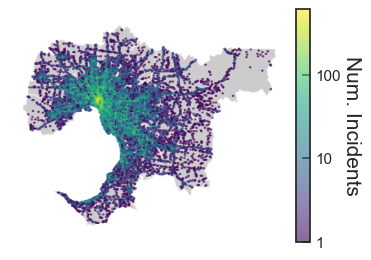

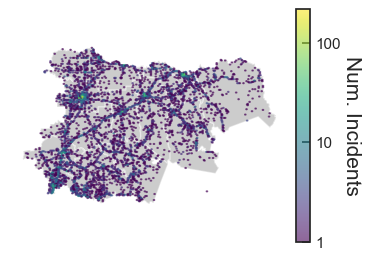

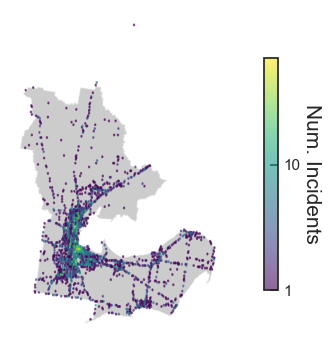

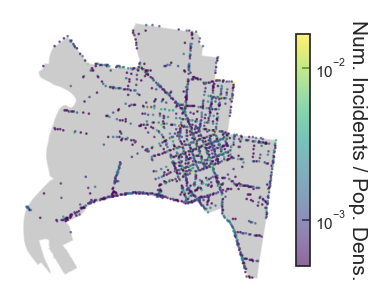

In [926]:
"""some EDA and plots before we run our analysis
let's first take a look at accidents that occur at various regions of vic.

did not want to install a misc package to convert GeoPoints into coordinates before using a heatmap,
verified that projection effect is minor victoria, and has no impact on the overall message of the plot.

for this particular case, we do not actually need geopandas - but if you wanted to be marginally more accurate
in your plots, you would use the geoplot package.
"""
def plot_locale_incidents(df, key='greatermelb', norm=None, figsize=(4,4), gridsize=200, save=False):
    """node df has been corrected such that we have 1 LGA_NAME per ACCIDENT_NO
    
    experimental norm, is normalized by LGA pop. dens after assuming traffic incidents is proportional this
    quantity. however this may not be the case, for example traffic routes toward major hubs across regional
    vic. use this flag appropriately
    """
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(7, 2, width_ratios=[1,0.05])
    gs.update(wspace=0.05, bottom=0.1, top=0.92, left=0.1, right=0.85)

    ax1 = fig.add_subplot(gs[:,0])
    ax2 = fig.add_subplot(gs[1:6,1])
    
    reduce_c = None
    format_ = '%.0f'
    
    if key in lga_dict.keys():
        query_arr_ = lga_dict[key].iloc[:,0].to_list()
    else:
        assert key in vic_lga_map['NAME'].unique(), 'LGA not found in vic_lga_map, through the NAME column'
        query_arr_ = key
        
    if norm:
        norm = 1./df.query("LGA_NAME == @query_arr_").apply(lambda col: decode_lga_popdens[col['LGA_NAME']], axis=1)
        reduce_c = np.sum
        format_ = None
    
    vic_lga_map.query("STATE=='VIC' & NAME == @query_arr_").plot(ax = ax1, alpha=0.4, color='grey')
    hb = ax1.hexbin(
        df.query("LGA_NAME == @query_arr_")['Long'], 
        df.query("LGA_NAME == @query_arr_")['Lat'],
        C = norm,
        reduce_C_function = reduce_c,
        gridsize=gridsize, mincnt=1, bins='log', cmap='viridis', alpha=0.6)

    cbar = plt.colorbar(cax=ax2, mappable=hb, format=format_)
    
    cbar.ax.set_ylabel('Num. Incidents', fontsize=15, rotation=270,labelpad=15)
    
    if norm is not None:
        cbar.ax.set_ylabel(f'{cbar.ax.get_ylabel()} / Pop. Dens.')
    
    ax1.axis('off')
    cbar.ax.tick_params(which='both', direction='in')
    cbar.ax.minorticks_off()
    
    if save:
        plt.savefig(f'{save}/locale_{key}.png', dpi=300, bbox_inches = "tight", facecolor='none')
    
    plt.show()
    return
    
print(f'available regions: {lga_dict.keys()}')

plot_locale_incidents(node_df, gridsize=200)
plot_locale_incidents(node_df, key='hume')
plot_locale_incidents(node_df, key='GREATER GEELONG')
plot_locale_incidents(node_df, norm=True, key='MELBOURNE')


In [927]:
"""let's look at subsets of our data. as we're not training, it'll be easier to generate charts if we don't
one-hot them yet.

as person_df is not one-hotted, we are essentially looking at a table at a per-person instance.
each row represents the incidence and outcome of a person.

SEVERITY which represents the overall outcome should not be plotted
"""

merged_eda_list = [acc_df, weather_df, surface_df, node_df, person_df]
merged_eda_df = functools.reduce(lambda l, r: pd.merge(l, r, left_index=True, right_index=True), merged_eda_list).reset_index()
merged_eda_df.head()

,ACCIDENT_NO,ACCIDENTTIME,Accident Type Desc,DCA Description,Light Condition Desc,Road Geometry Desc,SEVERITY,SPEED_ZONE,Atmosph Cond Desc,Surface Cond Desc,LGA_NAME,Lat,Long,SEX,Age Group,Inj Level Desc,Road User Type Desc
0,T20060000010,12:42:00,Collision with vehicle,RIGHT NEAR (INTERSECTIONS ONLY),Day,Cross intersection,3,60,Clear,Dry,GREATER DANDENONG,-37.988622,145.218049,F,unknown,Not injured,Passengers
1,T20060000010,12:42:00,Collision with vehicle,RIGHT NEAR (INTERSECTIONS ONLY),Day,Cross intersection,3,60,Clear,Dry,GREATER DANDENONG,-37.988622,145.218049,M,40-49,Not injured,Passengers
2,T20060000010,12:42:00,Collision with vehicle,RIGHT NEAR (INTERSECTIONS ONLY),Day,Cross intersection,3,60,Clear,Dry,GREATER DANDENONG,-37.988622,145.218049,M,22-25,Not injured,Passengers
3,T20060000010,12:42:00,Collision with vehicle,RIGHT NEAR (INTERSECTIONS ONLY),Day,Cross intersection,3,60,Clear,Dry,GREATER DANDENONG,-37.988622,145.218049,M,70+,Not injured,Drivers
4,T20060000010,12:42:00,Collision with vehicle,RIGHT NEAR (INTERSECTIONS ONLY),Day,Cross intersection,3,60,Clear,Dry,GREATER DANDENONG,-37.988622,145.218049,F,60-64,Other injury,Drivers


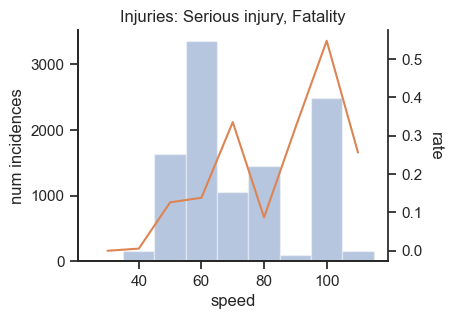

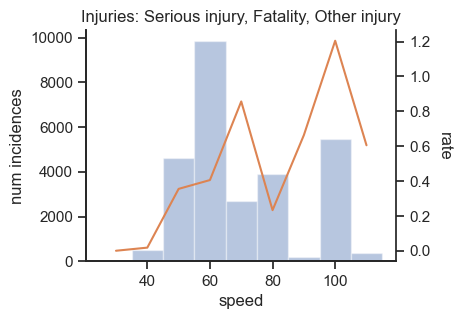

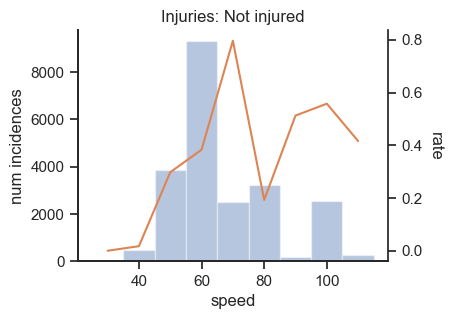

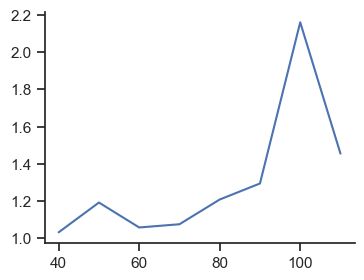

In [930]:
"""start with something easy. filter by 'Fatality' and 'Serious injury'

for normalization, we'll grab the road database and normalize by number of roads at that speed.

min_speed here is 30kmph
"""
min_speed = 30
max_speed = 130
bin_size= 10

speed_round = speed_map.apply(lambda c: int((c['SIGN_SPEED']//10) *10), axis=1)
speed_dist = speed_round.groupby(speed_round).size()
speed_dist = speed_dist[speed_dist.index >= min_speed]

inj_query = ['Serious injury', 'Fatality']

def plot_inj_speed(df, inj_query):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    h = ax1.hist(
        df.query("`Inj Level Desc` == @inj_query")['SPEED_ZONE'], 
        bins=np.arange(min_speed//bin_size, max_speed//bin_size)*bin_size - bin_size//2, 
        alpha=0.4
    )

    x_center = (h[1][:-1] + h[1][1:])/2
    ax2.plot(x_center, h[0]/speed_dist, color=CFG.col_array[1])
    
    ax1.set_xlabel('speed')
    ax1.set_ylabel('num incidences')
    ax2.set_ylabel('rate', rotation=-90, labelpad=15)
    ax2.spines.right.set_visible(True)

    ax1.set_title(f"Injuries: {', ' .join(inj_query)}")
    
    plt.show()
    return x_center, h[0]/speed_dist

plot_inj_speed(merged_eda_df, inj_query)

speed_x, inj_speed_ratio = plot_inj_speed(merged_eda_df, inj_query + ['Other injury'])
_, not_inj_speed_ratio =  plot_inj_speed(merged_eda_df, ['Not injured'])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(speed_x, inj_speed_ratio/not_inj_speed_ratio)

In [929]:
#speed_dist = speed_map.apply(lambda c: int((c['SIGN_SPEED']//10) *10), axis=1)

# (speed_map['SIGN_SPEED']//10)*10

In [869]:
(merged_eda_df['SPEED_ZONE']//10 * 10).unique()

array([ 60,  70, 100,  80,  50, 110,  90,  40])

In [606]:
"""let's merge everything into one DF, merge by ACCIDENT_NO index.

before we proceed, we need to one-hot these variables in these dfs:
    * weather_df (Atmosph Cond Desc)
    * surface_df (Suface Cond Desc)
    * person_df (Age Group, Road User Desc)
"""

weather_df = one_hot_preprocess(weather_df, col='Atmosph Cond Desc', )
surface_df = one_hot_preprocess(surface_df, col='Surface Cond Desc', )

merged_df_list = [acc_df, weather_df, surface_df, node_df]

merged_df = functools.reduce(lambda l, r: pd.merge(l, r, left_index=True, right_index=True), merged_df_list).reset_index()

#merged_df.groupby('ACCIDENT_NO').size().sort_values()
merged_df

,ACCIDENT_NO,ACCIDENTTIME,Accident Type Desc,DCA Description,Light Condition Desc,Road Geometry Desc,SEVERITY,SPEED_ZONE,cond_Clear,cond_Dust,cond_Fog,cond_Not known,cond_Raining,cond_Smoke,cond_Snowing,cond_Strong winds,cond_Dry,cond_Icy,cond_Muddy,cond_Snowy,cond_Unknown,cond_Wet,LGA_NAME,Lat,Long
0,T20060000010,12:42:00,Collision with vehicle,RIGHT NEAR (INTERSECTIONS ONLY),Day,Cross intersection,3,60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,GREATER DANDENONG,-37.988622,145.218049
1,T20060000018,19:10:00,Collision with vehicle,RIGHT NEAR (INTERSECTIONS ONLY),Day,T intersection,3,70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CASEY,-37.990920,145.276320
2,T20060000022,12:10:00,Fall from or in moving vehicle,FELL IN/FROM VEHICLE,Day,Not at intersection,2,100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,MORNINGTON PENINSULA,-38.396320,144.854890
3,T20060000023,11:49:00,Collision with vehicle,REAR END(VEHICLES IN SAME LANE),Day,T intersection,2,80,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,GREATER DANDENONG,-37.989185,145.144961
4,T20060000026,10:45:00,Collision with vehicle,RIGHT THROUGH,Day,Not at intersection,3,50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,MORNINGTON PENINSULA,-38.372990,144.871594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19465,T20070020900,08:00:00,Struck Pedestrian,ANY MANOEUVRE INVOLVING PED NOT INCLUDED IN DCAs 100-108.,Day,Not at intersection,2,999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,BRIMBANK,-37.787801,144.804400
19466,T20070020902,16:00:00,Struck animal,STRUCK ANIMAL,Day,Not at intersection,3,80,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CASEY,-38.004642,145.261079
19467,T20070020904,13:10:00,Collision with vehicle,LEFT TURN SIDESWIPE,Day,Not at intersection,3,70,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,KNOX,-37.891631,145.257931
19468,T20070020906,12:20:00,Collision with vehicle,LANE CHANGE RIGHT (NOT OVERTAKING),Day,Not at intersection,3,60,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,PORT PHILLIP,-37.875010,144.991460


In [610]:
person_df.drop()

,SEX,Age Group,Inj Level Desc,Road User Type Desc
ACCIDENT_NO,,,,
T20060000010,F,unknown,Not injured,Passengers
T20060000010,M,40-49,Not injured,Passengers
T20060000010,M,22-25,Not injured,Passengers
T20060000010,M,70+,Not injured,Drivers
T20060000010,F,60-64,Other injury,Drivers
...,...,...,...,...
T20060030034,M,26-29,Not injured,Drivers
T20060030035,M,50-59,Other injury,Pedestrians
T20060030035,U,unknown,Not injured,Drivers


In [565]:
person_df[person_df['Inj Level Desc'] == 'Not injured']

,SEX,Age Group,Inj Level Desc,Road User Type Desc
ACCIDENT_NO,,,,
T20060000010,F,unknown,Not injured,Passengers
T20060000010,M,40-49,Not injured,Passengers
T20060000010,M,22-25,Not injured,Passengers
T20060000010,M,70+,Not injured,Drivers
T20060000010,M,30-39,Not injured,Drivers
...,...,...,...,...
T20060030011,M,50-59,Not injured,Drivers
T20060030026,M,17-21,Not injured,Drivers
T20060030034,M,unknown,Not injured,Passengers


In [475]:
person_df[person_df.index == 'T20060018293']

,PERSON_ID,VEHICLE_ID,SEX,AGE,Age Group,INJ_LEVEL,Inj Level Desc,SEATING_POSITION,HELMET_BELT_WORN,ROAD_USER_TYPE,Road User Type Desc,LICENCE_STATE,PEDEST_MOVEMENT,POSTCODE,TAKEN_HOSPITAL,EJECTED_CODE
ACCIDENT_NO,,,,,,,,,,,,,,,,
T20060018293,01,,M,22,22-25,3,Other injury,,8,1,Pedestrians,V,1,3805,N,0
T20060018293,02,A,F,25,22-25,4,Not injured,LF,1,3,Passengers,V,0,3131,,0
T20060018293,A,A,M,23,22-25,4,Not injured,D,1,2,Drivers,V,0,,,0


In [126]:
acc_df[acc_df.index == 'T20060018293']

,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,DIRECTORY,EDITION,PAGE,GRID_REFERENCE_X,GRID_REFERENCE_Y,LIGHT_CONDITION,Light Condition Desc,NODE_ID,NO_OF_VEHICLES,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,NO_PERSONS_NOT_INJ,POLICE_ATTEND,ROAD_GEOMETRY,Road Geometry Desc,SEVERITY,SPEED_ZONE
ACCIDENT_NO,,,,,,,,,,,,,,,,,,,,,,,,,,,
T20060018293,7/05/2006,04:15:00,2,Struck Pedestrian,1,Sunday,100,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIGHT.,MEL,40,2L,J,9,3,Dark Street lights on,204422,1,3,0,1,0,2,1,5,Not at intersection,3,50


In [264]:
test = pd.read_csv(CFG.node_csv)[:CFG.num_samples]
test_pairs = pd.DataFrame(check_unique_pairs(test, 'POSTCODE_NO', 'NODE_ID'), columns=['a','b'])

test['DEG_URBAN_NAME'].unique()

[[  3000     83]
 [  3000    205]
 [  3000    206]
 ...
 [  3996  15518]
 [  3996  21037]
 [  3996 313252]]
mismatch


array(['MELB_URBAN', 'TOWNS', 'RURAL_VICTORIA', 'SMALL_TOWNS',
       'SMALL_CITIES', 'LARGE_PROVINCIAL_CITIES', 'MELBOURNE_CBD'],
      dtype=object)

In [187]:
street_map = gpd.read_file('shpfiles/AD_LGA_AREA_POLYGON.shp')

In [205]:
test_s = test.groupby(['Lat', 'Long']).size().to_frame().reset_index()

geometry = [Point(xy) for xy in zip(test['Long'], test['Lat'])]
geometry[:2]

geo_test = gpd.GeoDataFrame(test, crs=street_map.crs, geometry=geometry)

geo_test.head()

,ACCIDENT_NO,NODE_ID,NODE_TYPE,VICGRID94_X,VICGRID94_Y,LGA_NAME,LGA_NAME_ALL,REGION_NAME,DEG_URBAN_NAME,Lat,Long,POSTCODE_NO,geometry
0,T20060002689,22,I,2495701.925,2411599.135,MELBOURNE,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.796596,144.951197,3051,POINT (144.95120 -37.79660)
1,T20060010827,22,I,2495701.925,2411599.135,MELBOURNE,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.796596,144.951197,3051,POINT (144.95120 -37.79660)
2,T20060017279,22,I,2495701.925,2411599.135,MELBOURNE,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.796596,144.951197,3051,POINT (144.95120 -37.79660)
3,T20060041762,22,I,2495701.925,2411599.135,MELBOURNE,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.796596,144.951197,3051,POINT (144.95120 -37.79660)
4,T20060047478,22,I,2495701.925,2411599.135,MELBOURNE,MELBOURNE,METROPOLITAN NORTH WEST REGION,MELB_URBAN,-37.796596,144.951197,3051,POINT (144.95120 -37.79660)


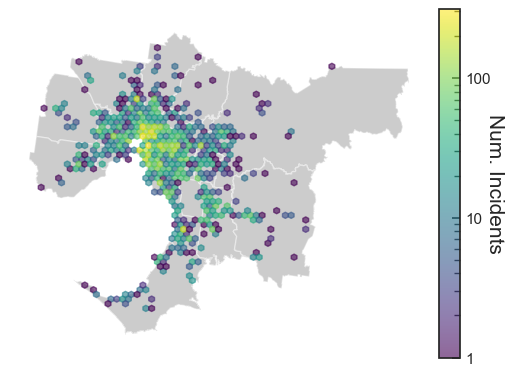

In [644]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(7,2,width_ratios=[1,0.05])
gs.update(wspace=0.05,bottom=0.1,top=0.92,left=0.1,right=0.85)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[1:6,1])

query_arr = lga_dict['greatermelb'].iloc[:,0].to_list()
street_map.query("STATE=='VIC' & NAME == @query_arr").plot(ax = ax1, alpha=0.4, color='grey')
d = ax1.hexbin(geo_test.query("LGA_NAME == @query_arr")['Long'], geo_test.query("LGA_NAME == @query_arr")['Lat'], gridsize=50, mincnt=1, bins='log', cmap='viridis', alpha=0.6)

cbar = plt.colorbar(cax=ax2, mappable=d, format='%.0f')
cbar.ax.set_ylabel('Num. Incidents', fontsize=15, rotation=270,labelpad=10)

ax1.axis('off')
cbar.ax.tick_params(which='both', direction='in')

In [835]:
speed_map = gpd.read_file('shpfiles/Speed_Signs.shp')

In [843]:
speed_map['round_down'] = speed_map.apply(lambda c: int((c['SIGN_SPEED']//10) *10), axis=1)

In [845]:
speed_map.groupby(['round_down']).size()

round_down
10       326
20       364
30       240
40     26866
50     12953
60     24256
70      3129
80     16656
90       318
100     4540
110      613
dtype: int64

In [842]:
55//10

5

In [349]:
for i in lga_dict:
    print(lga_dict[i]['Local government area'].isin(street_map.NAME.unique()))

#lga_dict['barwonsw']['Local government area'].to_numpy()

1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
Name: Local government area, dtype: bool
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
Name: Local government area, dtype: bool
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
Name: Local government area, dtype: bool
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
Name: Local government area, dtype: bool
1    True
2    True
3    True
4    True
5    True
6    True
Name: Local government area, dtype: bool
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     T

In [319]:
dfff = pd.read_csv('vic_lga/barwonsw.csv')[['Local government area', 'Population.1']].iloc[1:, :]

for i in lga_omit:
    dfff['Local government area'] = dfff['Local government area'].str.replace(i, "")
    
dfff['Local government area'] = dfff['Local government area'].str.upper()
dfff

,Local government area,Population.1
1,COLAC OTWAY,"22,423"
2,CORANGAMITE,"16,115"
3,GLENELG,"20,152"
4,GREATER GEELONG,"271,057"
5,MOYNE,"17,374"
6,BOROUGH QUEENSCLIFFE,"3,276"
7,SOUTHERN GRAMPIANS,"16,588"
8,SURF COAST,"37,694"
9,WARRNAMBOOL,"35,406"


In [690]:
pd.read_csv('vic_lga/greatermelb.csv')
#pd.read_csv('vic_lga/barwonsw.csv')

,Local government area,Council seat,Date established,Land area,Population (2021) [1],Pop. density,Councillors(2022),Map
0,City of Melbourne,Melbourne,12 August 1842,37 km2 (14 sq mi),"149,615","11,897",11,NaN
1,City of Port Phillip,St Kilda,22 June 1994,21 km2 (8.1 sq mi),"101,942","13,961",9,NaN
2,City of Stonnington,Malvern,22 June 1994,26 km2 (10 sq mi),"104,703","11,576",9,NaN
3,City of Yarra,Richmond,22 June 1994,20 km2 (7.7 sq mi),"90,114","12,758",9,NaN
4,City of Banyule,Greensborough,15 December 1994,63 km2 (24 sq mi),"126,236","5,354",9,NaN
5,City of Bayside,Sandringham,15 December 1994,37 km2 (14 sq mi),"101,306","7,400",7,NaN
6,City of Boroondara,Camberwell,22 June 1994,60 km2 (23 sq mi),"167,900","7,826",11,NaN
7,City of Darebin,Preston,22 June 1994,54 km2 (21 sq mi),"148,570","7,751",9,NaN
8,City of Glen Eira,Caulfield North,15 December 1994,39 km2 (15 sq mi),"148,908","10,218",9,NaN
9,City of Hobsons Bay,Altona,22 June 1994,64 km2 (25 sq mi),"91,322","3,904",7,NaN


In [314]:
pd.DataFrame(street_map.NAME.unique()).apply(lambda x: x.str.contains('RURAL')).sum()

0    0
dtype: int64

In [613]:
pd.read_csv(CFG.acc_csv, nrows=5000)

,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,DIRECTORY,EDITION,PAGE,GRID_REFERENCE_X,GRID_REFERENCE_Y,LIGHT_CONDITION,Light Condition Desc,NODE_ID,NO_OF_VEHICLES,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,NO_PERSONS_NOT_INJ,POLICE_ATTEND,ROAD_GEOMETRY,Road Geometry Desc,SEVERITY,SPEED_ZONE
0,T20060000010,13/01/2006,12:42:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,40.0,91A,G,7.0,1,Day,43078,3,6,0,1,0,5,1,1,Cross intersection,3,60
1,T20060000018,13/01/2006,19:10:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,40.0,91,H,8.0,1,Day,29720,2,4,0,1,0,3,1,2,T intersection,3,70
2,T20060000022,14/01/2006,12:10:00,7,Fall from or in moving vehicle,7,Saturday,190,FELL IN/FROM VEHICLE,MEL,40.0,169,C,11.0,1,Day,203074,1,2,1,0,0,1,1,5,Not at intersection,2,100
3,T20060000023,14/01/2006,11:49:00,1,Collision with vehicle,7,Saturday,130,REAR END(VEHICLES IN SAME LANE),MEL,40.0,88,J,8.0,1,Day,55462,2,2,1,0,0,1,1,2,T intersection,2,80
4,T20060000026,14/01/2006,10:45:00,1,Collision with vehicle,7,Saturday,121,RIGHT THROUGH,MEL,40.0,169,G,5.0,1,Day,202988,2,3,0,3,0,0,1,5,Not at intersection,3,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,T20060019079,1/05/2006,17:30:00,1,Collision with vehicle,2,Monday,130,REAR END(VEHICLES IN SAME LANE),MEL,40.0,25,K,8.0,1,Day,207614,3,5,0,3,0,2,2,5,Not at intersection,3,90
4996,T20060019084,10/05/2006,16:35:00,2,Struck Pedestrian,4,Wednesday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT,MEL,40.0,2L,J,9.0,1,Day,204566,1,2,0,1,0,1,1,5,Not at intersection,2,40
4997,T20060019086,10/05/2006,17:00:00,6,Vehicle overturned (no collision),4,Wednesday,174,OUT OF CONTROL ON CARRIAGEWAY (ON STRAIGHT),VCS,9.0,73,G,4.0,2,Dusk/Dawn,204453,1,3,3,0,0,0,1,5,Not at intersection,2,80
4998,T20060019093,8/05/2006,11:00:00,1,Collision with vehicle,2,Monday,145,REVERSING IN STREAM OF TRAFFIC,MEL,40.0,67,F,4.0,1,Day,57542,2,2,0,1,0,1,2,1,Cross intersection,3,80
